<a href="https://colab.research.google.com/github/nazarb/Mining/blob/main/Mining_VGG16_wgs_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing of Woolf's 2018 approach to locate mines

Woolf, Timberlynn. 2018. ‘Deep Convolutional Neural Networks for Remote Sensing Investigation of Looting of the Archeological Site of Al-Lisht, Egypt. A Thesis Presented to the Faculty of the USC Graduate School University of Southern California In Partial Fulfillment of the Requirements for the Degree Master of Science (GEOGRAPHIC INFORMATION SCIENCE AND TECHNOLOGY)’. Master of Science, University of Southern California.

Zaimportuj biblioteki i model VGG16



In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fid = drive.ListFile({'q':"title='WeS_11.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('WeS_11.zip')


In [ ]:
!unzip "/content/WeS_11.zip"

Archive:  /content/WeS_11.zip
   creating: WeS_11/COCO/
   creating: WeS_11/COCO/annotations/
   creating: WeS_11/COCO/eval/
   creating: WeS_11/COCO/eval/annotations/
  inflating: WeS_11/COCO/eval/eval.txt  
   creating: WeS_11/COCO/eval/image/
  inflating: WeS_11/COCO/eval/image/104.tif  
  inflating: WeS_11/COCO/eval/image/110.tif  
  inflating: WeS_11/COCO/eval/image/120.tif  
  inflating: WeS_11/COCO/eval/image/126.tif  
  inflating: WeS_11/COCO/eval/image/129.tif  
  inflating: WeS_11/COCO/eval/image/130.tif  
  inflating: WeS_11/COCO/eval/image/131.tif  
  inflating: WeS_11/COCO/eval/image/139.tif  
  inflating: WeS_11/COCO/eval/image/160.tif  
  inflating: WeS_11/COCO/eval/image/172.tif  
  inflating: WeS_11/COCO/eval/image/174.tif  
  inflating: WeS_11/COCO/eval/image/175.tif  
  inflating: WeS_11/COCO/eval/image/192.tif  
  inflating: WeS_11/COCO/eval/image/198.tif  
  inflating: WeS_11/COCO/eval/image/203.tif  
  inflating: WeS_11/COCO/eval/image/208.tif  
  inflating: WeS_1

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers

Pobierz parametry modelu VGG16

In [ ]:
print("Starting image classification process...")
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))
print("VGG16 base summary: " + str(conv_base.summary()))
print("Starting training data augmentation")
print("Starting feature extration process...")

Starting image classification process...
58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                     

Wybierz lokalizację gdzie są dane

In [ ]:
base_dir = '/content/WeS_11/COCO'
print("Using base directory for training, validation and test images: " + base_dir)

Using base directory for training, validation and test images: /content/WeS_11/COCO


Lokalizacja danych do train, validation i test; Zeskaluj obrazu i wybierz wielkość grup

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'eval')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [ ]:
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 15, 15, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
      target_size=(500, 500),
      batch_size=batch_size,
      class_mode='binary')
  i = 0
  
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
    return features, labels

Run and check

In [ ]:
print("Starting feature extration process on training images...")
train_features, train_labels = extract_features(train_dir, 400)
print("Ending feature extration process on training images...")
print("Starting feature extration process on validation images...")


Starting feature extration process on training images...
Found 400 images belonging to 2 classes.
1/1 [==============================] - 77s 77s/step
Ending feature extration process on training images...
Starting feature extration process on validation images...


In [ ]:
validation_features, validation_labels = extract_features(validation_dir, 50)
print("Ending feature extration process on validation images...")
print("Starting feature extration process on test images...")


Found 50 images belonging to 2 classes.
1/1 [==============================] - 66s 66s/step
Ending feature extration process on validation images...
Starting feature extration process on test images...


In [ ]:
test_features, test_labels = extract_features(test_dir, 50)
print("Ending feature extration process on test images...")
print("Ending feature extration process...")

Found 50 images belonging to 2 classes.
1/1 [==============================] - 65s 65s/step
Ending feature extration process on test images...
Ending feature extration process...


In [ ]:
train_features = np.reshape(train_features, (400, 15 * 15 * 512))
validation_features = np.reshape(validation_features, (50, 15 * 15 * 512))
test_features = np.reshape(test_features, (50, 15 * 15 * 512))
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=15 * 15 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
print("Starting training of NN on training, validation features...")
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

print("Ending training of NN on training, validation features...")


Starting training of NN on training, validation features...
Epoch 1/30
20/20 [==============================] - 13s 568ms/step - loss: 0.6622 - acc: 0.9475 - val_loss: 0.4158 - val_acc: 1.0000
Epoch 2/30
20/20 [==============================] - 11s 548ms/step - loss: 0.6581 - acc: 1.0000 - val_loss: 0.4156 - val_acc: 1.0000
Epoch 3/30
20/20 [==============================] - 10s 458ms/step - loss: 0.6579 - acc: 1.0000 - val_loss: 0.4155 - val_acc: 1.0000
Epoch 4/30
20/20 [==============================] - 11s 554ms/step - loss: 0.6577 - acc: 1.0000 - val_loss: 0.4154 - val_acc: 1.0000
Epoch 5/30
20/20 [==============================] - 12s 625ms/step - loss: 0.6576 - acc: 1.0000 - val_loss: 0.4152 - val_acc: 1.0000
Epoch 6/30
20/20 [==============================] - 9s 459ms/step - loss: 0.6574 - acc: 1.0000 - val_loss: 0.4151 - val_acc: 1.0000
Epoch 7/30
20/20 [==============================] - 11s 555ms/step - loss: 0.6572 - acc: 1.0000 - val_loss: 0.4150 - val_acc: 1.0000
Epoch 8/30

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

Wyświetl na wykresie

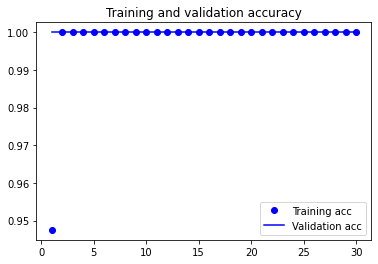

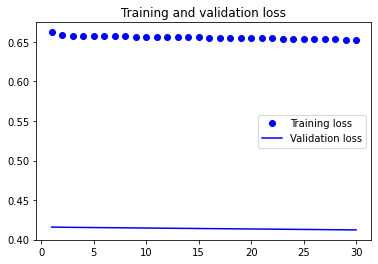

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
print("Starting models evaluation of NN on test dataset...")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(500, 500),
                                                  batch_size=20,
                                                  class_mode='binary')

test_loss_and_metrics = model.evaluate(test_features, test_labels)
print("Ending evaluation of NN on test dataset...")
print('Available test metrics: ', str(model.metrics_names))
print('CNN model loss and accuracy on test dataset: ', str(test_loss_and_metrics))

print("Starting prediction on test dataset...")
predictions = model.predict(test_features)
print(predictions)
print("Ending prediction on test dataset...")
print("Ending image classification process...")
print("Done")

Starting models evaluation of NN on test dataset...
Found 50 images belonging to 2 classes.
2/2 [==============================] - 0s 50ms/step - loss: 0.4122 - acc: 1.0000
Ending evaluation of NN on test dataset...
Available test metrics:  ['loss', 'acc']
CNN model loss and accuracy on test dataset:  [0.41224679350852966, 1.0]
Starting prediction on test dataset...
2/2 [==============================] - 0s 34ms/step
[[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.49695614]
 [0.4